This notebook uses matrix-based entropy [1, 2, 3] to analyze the "mutual information plane" of pretrained LLMs. For an introduction to this, check out the sentence_entropies.ipynb notebook.

Authors: Oscar Skean

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
import torch
import numpy as np
import tqdm
from utils import get_model_path, get_dataloader, normalize
import repitl.matrix_itl as itl

device = "cuda:1"

# Information Plane

The information plane is a probe on the model to analyze the mutual information between a pair of variables (input/output, input/layer representation, output/layer representation, etc.) as some quantity is changed (layer depth, context length, etc.).

In [7]:
def compute_information_plane(model, dataloader, var_A, var_B='layer', alpha=1):
    assert var_A in ['input', 'output']
    assert var_B in ['layer', 'output']

    mi_list = []
    counter = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader):
            counter += 1
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            N, D = outputs.hidden_states[0].shape[1:]

            if var_A == 'input':
                 # not really input, but the first hidden state
                A = normalize(outputs.hidden_states[0].squeeze())
            elif var_A == 'output':
                A = normalize(outputs.last_hidden_state.squeeze())

            if var_B == 'layer':
                B_list = [normalize(x.squeeze()) for x in outputs.hidden_states[1:]]
            if var_B == 'output':
                B_list = [normalize(outputs.last_hidden_state.squeeze())]
            
            # get the covariance matrix for variable A
            if N > D:
                A_cov = A.T @ A
            else:
                A_cov = A @ A.T
            A_cov /= torch.trace(A_cov)
            A_cov = torch.clamp(A_cov, min=0)

            # get the covariance matrix for variable B
            B_cov_list = []
            for B in B_list:
                B = B.squeeze()
                if N > D:
                    B_cov = B.T @ B
                else:
                    B_cov = B @ B.T
                B_cov /= torch.trace(B_cov)
                B_cov = torch.clamp(B_cov, min=0)
                B_cov_list.append(B_cov)

            # compute the mutual information between A and each B
            mutual_informations = []
            entropy_A = itl.matrixAlphaEntropy(A_cov, alpha=alpha)
            for B_cov in B_cov_list:
                entropy_B = itl.matrixAlphaEntropy(B_cov, alpha=alpha)
                entropy_joint = itl.matrixAlphaEntropy(torch.pow(A_cov * B_cov, 0.5), alpha=alpha)


                mi = entropy_A + entropy_B - entropy_joint
                mutual_informations.append(mi.item())

            mi_list.append(mutual_informations)
            if counter > 300:
                break

    return mi_list

In [8]:
input_to_layer_infos = {}
output_to_layer_infos = {}

for model_size in ['14m', '70m', '160m', '410m']:
    model_path = get_model_path("EleutherAI", model_size)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to("cuda:1")
    dataloader = get_dataloader(tokenizer, "wikitext", split="train")

    input_to_layer_infos[model_size] = np.array(compute_information_plane(model, dataloader, "input", "layer", alpha=1)).mean(axis=0)
    output_to_layer_infos[model_size] = np.array(compute_information_plane(model, dataloader, "output", "layer", alpha=1)).mean(axis=0)

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  6%|▋         | 300/4781 [00:08<02:01, 36.80it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  6%|▋         | 300/4781 [00:12<03:07, 23.89it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  6%|▋         | 300/4781 [00:24<05:59, 12.47it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  6%|▋         | 300/4781 [00:47<11:49,  6.31it/s]


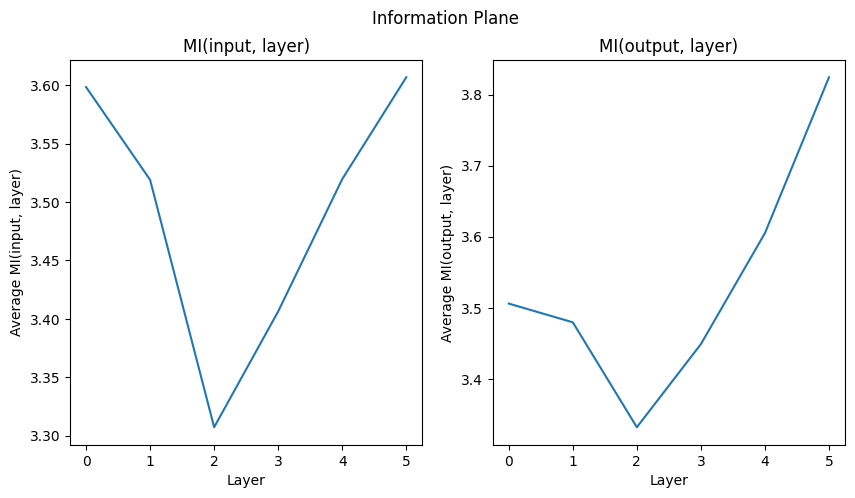

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(input_to_layer_infos['14m'], label="MI(input, layer)")
axes[0].set_title("MI(input, layer)")
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Average MI(input, layer)")

axes[1].plot(output_to_layer_infos['14m'], label="MI(output, layer)")
axes[1].set_title("MI(output, layer)")
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Average MI(output, layer)")

fig.suptitle("Information Plane")
plt.show()

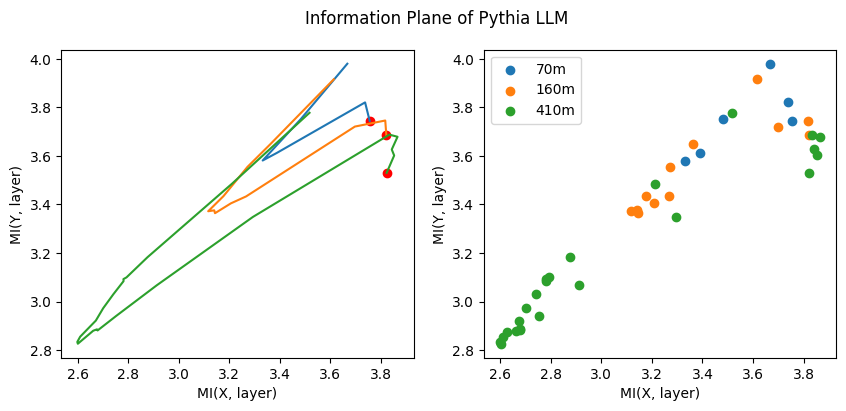

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for model_size in ['70m', '160m', '410m']:
    axes[0].plot(input_to_layer_infos[model_size], output_to_layer_infos[model_size], label=model_size)
    axes[1].scatter(input_to_layer_infos[model_size], output_to_layer_infos[model_size], label=model_size)

    # highlight first point
    axes[0].scatter(input_to_layer_infos[model_size][0], output_to_layer_infos[model_size][0], color='red')

axes[0].set_xlabel("MI(X, layer)")
axes[0].set_ylabel("MI(Y, layer)")
axes[1].set_xlabel("MI(X, layer)")
axes[1].set_ylabel("MI(Y, layer)")
plt.suptitle("Information Plane of Pythia LLM")
plt.legend()